In [121]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder, PowerTransformer, StandardScaler, \
                                    MinMaxScaler, FunctionTransformer, OneHotEncoder
from sklearn.metrics import roc_auc_score, log_loss, classification_report
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline, make_union, make_pipeline
from sklearn.decomposition import PCA
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from function_dt_check import time_checker
import json

In [2]:
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Hancom Gothic'
plt.style.use('bmh')
plt.rc('font',size=15)

In [3]:
path = './data/'
train = pd.read_csv(path+'train.csv')
train = train.drop(['index'], axis=1)

test = pd.read_csv(path+'test.csv')
test = test.drop(['index'], axis=1)

submission = pd.read_csv(path+'sample_submission.csv')

In [4]:
X_train, y_train = train.iloc[:,:-1], train.iloc[:,-1]

In [5]:
cat_columns = [c for c, t in zip(X_train.dtypes.index, X_train.dtypes) if t == 'O'] 
num_columns = [c for c    in X_train.columns if c not in cat_columns]

In [6]:
train.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


In [7]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         26457 non-null  object 
 1   car            26457 non-null  object 
 2   reality        26457 non-null  object 
 3   child_num      26457 non-null  int64  
 4   income_total   26457 non-null  float64
 5   income_type    26457 non-null  object 
 6   edu_type       26457 non-null  object 
 7   family_type    26457 non-null  object 
 8   house_type     26457 non-null  object 
 9   DAYS_BIRTH     26457 non-null  int64  
 10  DAYS_EMPLOYED  26457 non-null  int64  
 11  FLAG_MOBIL     26457 non-null  int64  
 12  work_phone     26457 non-null  int64  
 13  phone          26457 non-null  int64  
 14  email          26457 non-null  int64  
 15  occyp_type     18286 non-null  object 
 16  family_size    26457 non-null  float64
 17  begin_month    26457 non-null  float64
dtypes: flo

In [8]:
train.isna().sum()

gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
credit              0
dtype: int64

### occyp_type만 결측치 존재

In [9]:
y_train.value_counts()

2.0    16968
1.0     6267
0.0     3222
Name: credit, dtype: int64

### 클래스 불균형 존재

In [11]:
@time_checker
def train_model(x_data, y_data, params, k=5, num_boost_round = 200, verbose_eval = 100, early_stopping_rounds = 100, stratified = False, return_models = False):
    models = []
    
#     k_fold = KFold(n_splits=k, shuffle=True, random_state=123)
    if stratified:
        k_fold = StratifiedKFold(n_splits=k, shuffle=True, random_state=123)
        data = [x_data, y_data]
    else:
        k_fold = KFold(n_splits=k, shuffle=True, random_state=123)
        data = [x_data]
#     k_fold = StratifiedKFold(n_splits=k, shuffle=True, random_state=123) if stratified else KFold(n_splits=k, shuffle=True, random_state=123)
    
    
    for train_idx, val_idx in k_fold.split(*data):
        x_train, y_train = x_data.iloc[train_idx], y_data.iloc[train_idx]
        x_val, y_val = x_data.iloc[val_idx], y_data.iloc[val_idx]
    
        d_train = xgb.DMatrix(data = x_train, label = y_train)
        d_val = xgb.DMatrix(data = x_val, label = y_val)
        
        wlist = [(d_train, 'train'), (d_val, 'eval')]
        
        model = xgb.train(params=params, dtrain=d_train, num_boost_round = num_boost_round, evals=wlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=verbose_eval)
        models.append(model)
    
    print(f"{k} fold mean score:", np.mean([i.best_score for i in models]))
    
    if return_models:
        return models

@time_checker
def last_train(X_test, y_test, params, num_boost_round = 200):
    print("***최종 학습 전 하이퍼 파라미터 다시한번 확인!!***")
    
    d_test = xgb.DMatrix(data = X_test, label = y_test)
    model = xgb.train(params = params, dtrain = d_test, num_boost_round = num_boost_round)
    
    return model

def get_XGBparams(booster):
    config = json.loads(booster.save_config()) # your xgb booster object
    stack = [config]
    internal = {}
    while stack:
        obj = stack.pop()
        for k, v in obj.items():
            if k.endswith('_param'):
                for p_k, p_v in v.items():
                    internal[p_k] = p_v
            elif isinstance(v, dict):
                stack.append(v)
    return internal

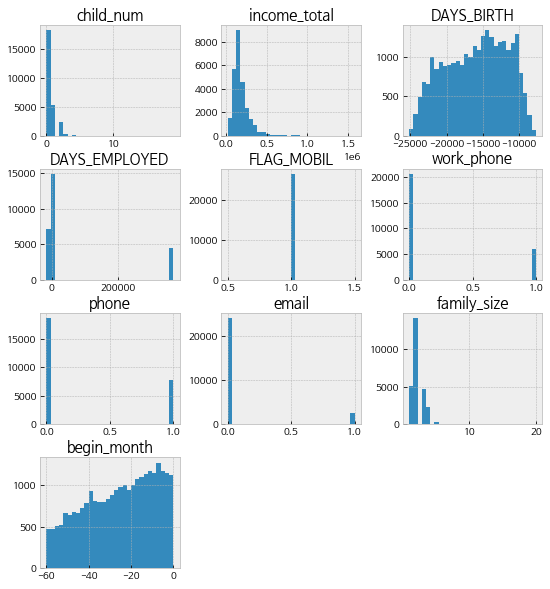

In [12]:
plt.rc('font', size = 10)
X_train[num_columns].hist(figsize = (9, 10), bins=30);

In [13]:
X_train['FLAG_MOBIL'].value_counts()

1    26457
Name: FLAG_MOBIL, dtype: int64

In [14]:
test['FLAG_MOBIL'].value_counts()

1    10000
Name: FLAG_MOBIL, dtype: int64

FLAG_MOBILE은 모든 값이 1이므로 삭제

In [15]:
X_train = X_train.drop('FLAG_MOBIL', axis = 1)
test = test.drop('FLAG_MOBIL', axis = 1)
num_columns.remove("FLAG_MOBIL")

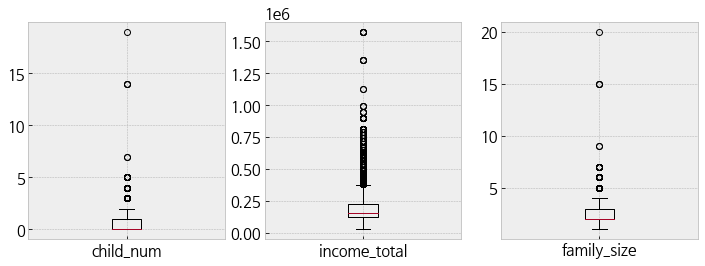

In [16]:
plt.figure(figsize = (12, 4))
plt.rc('font', size = 15)

plt.subplot(1,3,1)
plt.boxplot(X_train['child_num']);
plt.xticks([1], ['child_num'])

plt.subplot(1,3,2)
plt.boxplot(X_train['income_total']);
plt.xticks([1], ['income_total'])

plt.subplot(1,3,3)
plt.boxplot(X_train['family_size']);
plt.xticks([1], ['family_size']);

In [20]:
skew_col = ['child_num', 'income_total', 'family_size']
OH_col = ['income_type', 'family_type', 'house_type', 'occyp_type']

In [21]:
pipline = Pipeline([
        ("stdard_scaler", StandardScaler()),
        ("Yeo-Johnson", PowerTransformer(method='yeo-johnson'))
    ])

In [22]:
pipline.fit_transform(X_train[skew_col])

array([[-0.6630603 ,  0.46990897, -0.06168216],
       [ 1.39481456,  0.87925267,  0.96173668],
       [-0.6630603 ,  1.96426356, -0.06168216],
       ...,
       [-0.6630603 ,  1.19725036, -0.06168216],
       [-0.6630603 ,  0.09046305, -1.62051665],
       [-0.6630603 , -1.54591439, -0.06168216]])

In [23]:
def data_preprocessing(data, fit_transform = False, piplines = None):
    
    if fit_transform == False:
        assert piplines, 'If fit_transform is false, pipline must be passed'
    
    proc_data = data.copy()
    
    for i in proc_data[cat_columns].columns:
        unique = proc_data[i].unique()
        if len(unique) == 2:
            proc_data[i] = proc_data[i].apply(lambda x:1 if x == unique[0] else 0)
            
    proc_data = proc_data.fillna("missing")
    
    proc_data = pd.get_dummies(proc_data, columns = OH_col)
    
    proc_data['edu_type'] = proc_data['edu_type'].replace({'Lower secondary':0,
                                                           'Secondary / secondary special':1,
                                                           'Incomplete higher':2,
                                                           'Higher education':3,
                                                           'Academic degree':4})
    cols = proc_data.columns

    if fit_transform:
        std_scaler = StandardScaler()
        YJ_transf = PowerTransformer(method='yeo-johnson')
        
        proc_data = std_scaler.fit_transform(proc_data)
        proc_data = pd.DataFrame(proc_data, columns=cols)
        proc_data[skew_col] = YJ_transf.fit_transform(proc_data[skew_col])
        
        return proc_data, [std_scaler, YJ_transf]
    
    else:
        std_scaler = piplines[0]
        YJ_transf = piplines[1]
        
        proc_data = std_scaler.transform(proc_data)
        proc_data = pd.DataFrame(proc_data, columns=cols)
        proc_data[skew_col] = YJ_transf.transform(proc_data[skew_col])
        
        return proc_data
        

In [24]:
x_train, piplines = data_preprocessing(X_train, fit_transform = True)
x_test = data_preprocessing(test, piplines = piplines)

In [25]:
piplines

[StandardScaler(), PowerTransformer()]

In [26]:
x_train.isna().sum()

gender                              0
car                                 0
reality                             0
child_num                           0
income_total                        0
edu_type                            0
DAYS_BIRTH                          0
DAYS_EMPLOYED                       0
work_phone                          0
phone                               0
email                               0
family_size                         0
begin_month                         0
income_type_Commercial associate    0
income_type_Pensioner               0
income_type_State servant           0
income_type_Student                 0
income_type_Working                 0
family_type_Civil marriage          0
family_type_Married                 0
family_type_Separated               0
family_type_Single / not married    0
family_type_Widow                   0
house_type_Co-op apartment          0
house_type_House / apartment        0
house_type_Municipal apartment      0
house_type_O

In [27]:
len(X_train['occyp_type'].unique()) == len([col for col in x_train.keys() if col.startswith("occyp")])

True

### 생각해 볼점
유일하게 결측치가 존재하는 컬럼인 occyp_type은 직업 유형을 나타낸 컬럼임. 생각해 볼 2가지 처리 방법이 있음.
1. occyp_type은 카테고리형 데이터 임 -> 결측되었다는 정보 자체를 하나의 컬럼으로 onehot incoding한 후 모델에 넣어서 돌리기
2. MICE로 imputation한 후 돌리기

우선 1안으로 실험

In [28]:
x_train.shape, y_train.shape

((26457, 48), (26457,))

In [29]:
xgb_params = {
    'booster': 'gbtree',
    'learning_rate': 0.3,
    'gamma': 0.3,
    'max_depth': 3,
#     'objective': 'multi:softmax',
    'objective': 'multi:softprob',
    'num_class': 3,
    'eval_metric': 'mlogloss',
    'seed':1324
    }

In [30]:
pca = PCA(n_components=0.8)
x_train_pca = pca.fit_transform(x_train)
x_train_pca.shape

(26457, 29)

In [31]:
models = train_model(x_train, y_train, xgb_params, num_boost_round = 700, stratified = True, return_models=True)

[0]	train-mlogloss:0.97811	eval-mlogloss:0.97988
[100]	train-mlogloss:0.73846	eval-mlogloss:0.78894
[200]	train-mlogloss:0.69479	eval-mlogloss:0.77848
[300]	train-mlogloss:0.66432	eval-mlogloss:0.77257
[400]	train-mlogloss:0.64023	eval-mlogloss:0.76889
[500]	train-mlogloss:0.63552	eval-mlogloss:0.76789
[521]	train-mlogloss:0.63552	eval-mlogloss:0.76789
[0]	train-mlogloss:0.97843	eval-mlogloss:0.97925
[100]	train-mlogloss:0.73607	eval-mlogloss:0.78227
[200]	train-mlogloss:0.69351	eval-mlogloss:0.76772
[300]	train-mlogloss:0.66260	eval-mlogloss:0.75878
[400]	train-mlogloss:0.64080	eval-mlogloss:0.75387
[500]	train-mlogloss:0.63021	eval-mlogloss:0.75162
[548]	train-mlogloss:0.63021	eval-mlogloss:0.75162
[0]	train-mlogloss:0.97910	eval-mlogloss:0.97764
[100]	train-mlogloss:0.73998	eval-mlogloss:0.78022
[200]	train-mlogloss:0.69456	eval-mlogloss:0.76748
[300]	train-mlogloss:0.65817	eval-mlogloss:0.76010
[400]	train-mlogloss:0.63968	eval-mlogloss:0.75698
[500]	train-mlogloss:0.63488	eval-mlo

In [223]:
model = last_train(x_train, y_train, xgb_params, 700)

***최종 학습 전 하이퍼 파라미터 다시한번 확인!!***


In [224]:
result = model.predict(xgb.DMatrix(x_test))

In [225]:
result

array([[0.07346022, 0.12216133, 0.80437845],
       [0.12354086, 0.12117603, 0.75528306],
       [0.13675895, 0.22094147, 0.6422996 ],
       ...,
       [0.07561718, 0.20075288, 0.7236299 ],
       [0.0594825 , 0.18499026, 0.75552726],
       [0.08669662, 0.16240537, 0.750898  ]], dtype=float32)

In [230]:
submission[['0', '1', '2']] = result

In [231]:
submission.head()

,index,0,1,2
0,26457,0.073460,0.122161,0.804378
1,26458,0.123541,0.121176,0.755283
2,26459,0.136759,0.220941,0.642300
3,26460,0.165680,0.122165,0.712154
4,26461,0.059492,0.074284,0.866224


### oversampling

In [90]:
x_smote_resampled, y_smote_resampled = SMOTE().fit_resample(x_train, y_train)
x_adasyn_resampled, y_adasyn_resampled = ADASYN().fit_resample(x_train, y_train)
x_Bsmote_resampled, y_Bsmote_resampled = BorderlineSMOTE().fit_resample(x_train, y_train)

In [74]:
xr, xt, yr, yt = train_test_split(x_smote_resampled, y_smote_resampled, test_size = 0.3)

In [55]:
train_model(x_smote_resampled, y_smote_resampled, xgb_params, num_boost_round = 700, verbose_eval = 140)

[0]	train-mlogloss:1.07953	eval-mlogloss:1.08066
[140]	train-mlogloss:0.78609	eval-mlogloss:0.81230
[280]	train-mlogloss:0.67544	eval-mlogloss:0.71907
[420]	train-mlogloss:0.61614	eval-mlogloss:0.67706
[560]	train-mlogloss:0.57379	eval-mlogloss:0.65110
[699]	train-mlogloss:0.54338	eval-mlogloss:0.63543
[0]	train-mlogloss:1.07911	eval-mlogloss:1.07885
[140]	train-mlogloss:0.78676	eval-mlogloss:0.81972
[280]	train-mlogloss:0.67825	eval-mlogloss:0.73002
[420]	train-mlogloss:0.61510	eval-mlogloss:0.68381
[560]	train-mlogloss:0.58113	eval-mlogloss:0.66499
[678]	train-mlogloss:0.57939	eval-mlogloss:0.66395
[0]	train-mlogloss:1.07883	eval-mlogloss:1.07910
[140]	train-mlogloss:0.78528	eval-mlogloss:0.81634
[280]	train-mlogloss:0.67454	eval-mlogloss:0.72638
[420]	train-mlogloss:0.61510	eval-mlogloss:0.68331
[560]	train-mlogloss:0.57242	eval-mlogloss:0.65827
[699]	train-mlogloss:0.53984	eval-mlogloss:0.64011
[0]	train-mlogloss:1.07958	eval-mlogloss:1.08049
[140]	train-mlogloss:0.78060	eval-mlogl

In [56]:
train_model(x_adasyn_resampled, y_adasyn_resampled, xgb_params, num_boost_round = 700, verbose_eval = 140)

[0]	train-mlogloss:1.08005	eval-mlogloss:1.08113
[140]	train-mlogloss:0.79381	eval-mlogloss:0.82856
[280]	train-mlogloss:0.69057	eval-mlogloss:0.74808
[420]	train-mlogloss:0.63514	eval-mlogloss:0.71013
[560]	train-mlogloss:0.59453	eval-mlogloss:0.68551
[699]	train-mlogloss:0.56955	eval-mlogloss:0.67227
[0]	train-mlogloss:1.08031	eval-mlogloss:1.08002
[140]	train-mlogloss:0.79132	eval-mlogloss:0.81681
[280]	train-mlogloss:0.69223	eval-mlogloss:0.73769
[420]	train-mlogloss:0.63684	eval-mlogloss:0.70158
[560]	train-mlogloss:0.59765	eval-mlogloss:0.67871
[699]	train-mlogloss:0.57078	eval-mlogloss:0.66447
[0]	train-mlogloss:1.07903	eval-mlogloss:1.07926
[140]	train-mlogloss:0.79361	eval-mlogloss:0.81981
[280]	train-mlogloss:0.69478	eval-mlogloss:0.74141
[420]	train-mlogloss:0.63824	eval-mlogloss:0.70200
[560]	train-mlogloss:0.60176	eval-mlogloss:0.68135
[699]	train-mlogloss:0.57113	eval-mlogloss:0.66604
[0]	train-mlogloss:1.08010	eval-mlogloss:1.08082
[140]	train-mlogloss:0.78685	eval-mlogl

In [57]:
train_model(x_Bsmote_resampled, y_Bsmote_resampled, xgb_params, num_boost_round = 700, verbose_eval = 140)

[0]	train-mlogloss:1.07861	eval-mlogloss:1.08100
[140]	train-mlogloss:0.79320	eval-mlogloss:0.82096
[280]	train-mlogloss:0.68446	eval-mlogloss:0.72910
[420]	train-mlogloss:0.62273	eval-mlogloss:0.68178
[560]	train-mlogloss:0.58355	eval-mlogloss:0.65723
[699]	train-mlogloss:0.56297	eval-mlogloss:0.64442
[0]	train-mlogloss:1.07973	eval-mlogloss:1.07973
[140]	train-mlogloss:0.79157	eval-mlogloss:0.82097
[280]	train-mlogloss:0.67837	eval-mlogloss:0.72597
[420]	train-mlogloss:0.61765	eval-mlogloss:0.68279
[560]	train-mlogloss:0.58117	eval-mlogloss:0.66136
[699]	train-mlogloss:0.55068	eval-mlogloss:0.64343
[0]	train-mlogloss:1.07897	eval-mlogloss:1.07875
[140]	train-mlogloss:0.78851	eval-mlogloss:0.82002
[280]	train-mlogloss:0.67973	eval-mlogloss:0.73169
[420]	train-mlogloss:0.61797	eval-mlogloss:0.68645
[560]	train-mlogloss:0.57687	eval-mlogloss:0.66083
[699]	train-mlogloss:0.55437	eval-mlogloss:0.64807
[0]	train-mlogloss:1.07999	eval-mlogloss:1.08037
[140]	train-mlogloss:0.78636	eval-mlogl

In [75]:
xr = xr.reset_index(drop = True)
yr = yr.reset_index(drop = True)

In [35]:
xgb_params = {
    'booster': 'gbtree',
    'learning_rate': 0.3,
    'gamma': 1,
    'max_depth': 3,
#     'objective': 'multi:softmax',
    'objective': 'multi:softprob',
    'num_class': 3,
    'eval_metric': 'mlogloss',
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'gpu_id': 0, # GPU
    'tree_method': 'gpu_hist',
    'seed':1324
    }
models = train_model(x_adasyn_resampled, y_adasyn_resampled, xgb_params, num_boost_round = 1000, verbose_eval = 200, return_models = True)

[0]	train-mlogloss:1.08372	eval-mlogloss:1.08420
[200]	train-mlogloss:0.75172	eval-mlogloss:0.79053
[400]	train-mlogloss:0.66557	eval-mlogloss:0.72222
[600]	train-mlogloss:0.62674	eval-mlogloss:0.69467
[800]	train-mlogloss:0.60287	eval-mlogloss:0.68028
[999]	train-mlogloss:0.58176	eval-mlogloss:0.66799
[0]	train-mlogloss:1.08169	eval-mlogloss:1.08250
[200]	train-mlogloss:0.75429	eval-mlogloss:0.78921
[400]	train-mlogloss:0.66905	eval-mlogloss:0.72367
[600]	train-mlogloss:0.62933	eval-mlogloss:0.69687
[800]	train-mlogloss:0.60140	eval-mlogloss:0.67783
[999]	train-mlogloss:0.58204	eval-mlogloss:0.66677
[0]	train-mlogloss:1.08203	eval-mlogloss:1.08170
[200]	train-mlogloss:0.75252	eval-mlogloss:0.78560
[400]	train-mlogloss:0.66927	eval-mlogloss:0.72282
[600]	train-mlogloss:0.62712	eval-mlogloss:0.69278
[800]	train-mlogloss:0.59722	eval-mlogloss:0.67264
[999]	train-mlogloss:0.58022	eval-mlogloss:0.66338
[0]	train-mlogloss:1.08065	eval-mlogloss:1.08130
[200]	train-mlogloss:0.74764	eval-mlogl

SMOTE를 사용하여 oversampling 후 학습을 진행하였음.
학습시 train, valid, test score가 모두 올랐으나 제출하였을 때 점수는 그대로 였음. 
1. oversampling 이전에 먼저 test set을 분리 후 다시 실험
2. oversampling 폐기

우선 1안 수행

In [63]:
xr, xt, yr, yt = train_test_split(x_train, y_train, test_size = 0.3)
xr = xr.reset_index(drop = True)
yr = yr.reset_index(drop = True)
xt = xt.reset_index(drop = True)
yt = yt.reset_index(drop = True)

xr_adasyn, yr_adasyn = ADASYN().fit_resample(xr, yr)

xgb_params = {
    'booster': 'gbtree',
    'learning_rate': 0.3,
    'gamma': 1,
    'max_depth': 3,
#     'objective': 'multi:softmax',
    'objective': 'multi:softprob',
    'num_class': 3,
    'eval_metric': 'mlogloss',
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'gpu_id': 0, # GPU
    'tree_method': 'gpu_hist',
    'seed':1324
    }

models = train_model(xr_adasyn, yr_adasyn, 
                     xgb_params, num_boost_round = 300, 
                     verbose_eval = 200, return_models = True)

[0]	train-mlogloss:1.07715	eval-mlogloss:1.07692
[200]	train-mlogloss:0.72137	eval-mlogloss:0.77580
[299]	train-mlogloss:0.67776	eval-mlogloss:0.74569
[0]	train-mlogloss:1.07928	eval-mlogloss:1.07897
[200]	train-mlogloss:0.72508	eval-mlogloss:0.77172
[299]	train-mlogloss:0.67774	eval-mlogloss:0.73716
[0]	train-mlogloss:1.07946	eval-mlogloss:1.08024
[200]	train-mlogloss:0.72229	eval-mlogloss:0.77247
[299]	train-mlogloss:0.67820	eval-mlogloss:0.74186
[0]	train-mlogloss:1.08215	eval-mlogloss:1.08230
[200]	train-mlogloss:0.72698	eval-mlogloss:0.77031
[299]	train-mlogloss:0.67951	eval-mlogloss:0.73651
[0]	train-mlogloss:1.07855	eval-mlogloss:1.08060
[200]	train-mlogloss:0.72133	eval-mlogloss:0.78028
[299]	train-mlogloss:0.67555	eval-mlogloss:0.75020
5 fold mean score: 0.7422826
train_model learning time: 12.860954761505127


In [64]:
for mod in models:
    print(log_loss(pd.get_dummies(yt), mod.predict(xgb.DMatrix(xt))))

0.821183249687799
0.8191319213123956
0.8234893858442625
0.820938087168224
0.8210951507285812


train-test split --> train data oversampling --> training & test 순서로 실험결과 성능 향상 없이 과적합 발생
- [ ] oversampling 이전에 먼저 test set을 분리 후 다시 실험
- [x] **oversampling 폐기**

### downsampling

In [115]:
from imblearn.under_sampling import OneSidedSelection, TomekLinks, RandomUnderSampler

In [99]:
xr, xt, yr, yt = train_test_split(x_train, y_train, test_size = 0.3, stratify = y_train)
xr = xr.reset_index(drop = True)
yr = yr.reset_index(drop = True)
xt = xt.reset_index(drop = True)
yt = yt.reset_index(drop = True)

xr_OSS, yr_OSS = OneSidedSelection(random_state = 756).fit_resample(xr, yr)

xgb_params = {
    'booster': 'gbtree',
    'learning_rate': 0.3,
    'gamma': 1,
    'max_depth': 3,
#     'objective': 'multi:softmax',
    'objective': 'multi:softprob',
    'num_class': 3,
    'eval_metric': 'mlogloss',
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'gpu_id': 0, # GPU
    'tree_method': 'gpu_hist',
    'seed':1324
    }

models = train_model(xr_OSS, yr_OSS, 
                     xgb_params, num_boost_round = 1000, 
                     verbose_eval = 200, return_models = True)

[0]	train-mlogloss:0.99086	eval-mlogloss:0.98780
[200]	train-mlogloss:0.67338	eval-mlogloss:0.74306
[400]	train-mlogloss:0.62645	eval-mlogloss:0.73616
[600]	train-mlogloss:0.59688	eval-mlogloss:0.72792
[796]	train-mlogloss:0.57773	eval-mlogloss:0.72838
[0]	train-mlogloss:0.98974	eval-mlogloss:0.99067
[200]	train-mlogloss:0.66819	eval-mlogloss:0.76143
[400]	train-mlogloss:0.62329	eval-mlogloss:0.75162
[600]	train-mlogloss:0.59633	eval-mlogloss:0.74819
[709]	train-mlogloss:0.58529	eval-mlogloss:0.74949
[0]	train-mlogloss:0.98904	eval-mlogloss:0.99218
[200]	train-mlogloss:0.66755	eval-mlogloss:0.77176
[400]	train-mlogloss:0.61963	eval-mlogloss:0.76616
[600]	train-mlogloss:0.59127	eval-mlogloss:0.76260
[685]	train-mlogloss:0.58295	eval-mlogloss:0.76318
[0]	train-mlogloss:0.98997	eval-mlogloss:0.99095
[200]	train-mlogloss:0.67060	eval-mlogloss:0.76603
[400]	train-mlogloss:0.61864	eval-mlogloss:0.75692
[600]	train-mlogloss:0.59189	eval-mlogloss:0.75430
[800]	train-mlogloss:0.57006	eval-mlogl

In [122]:
for mod in models:
    print(log_loss(pd.get_dummies(yt), mod.predict(xgb.DMatrix(xt))))

0.799569799785701
0.8046685516094879
0.7991811307914448
0.8073127097497127
0.8058707364545054


In [136]:
print(classification_report(yt.values, np.argmax(mod.predict(xgb.DMatrix(xt)), axis=1)))

              precision    recall  f1-score   support

         0.0       0.40      0.07      0.12       967
         1.0       0.68      0.26      0.37      1880
         2.0       0.70      0.97      0.81      5091

    accuracy                           0.69      7938
   macro avg       0.59      0.43      0.44      7938
weighted avg       0.66      0.69      0.62      7938



In [146]:
yt.value_counts()

2.0    5091
1.0    1880
0.0     967
Name: credit, dtype: int64